# Tourist satisfaction with transport systems to Mount Etna, Sicily. Part 2. Classification.

# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Academy/+ Papers/en_proceso/mount_etna/'


In [94]:
base_dir = '../' # To run locally

# 1. Data pre-processing

In [95]:
#!pip install pycaret[full]

## Importing libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import spacy
import imblearn
import matplotlib.font_manager
#spacy.load("en_core_web_sm")

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Libraries read!')

Libraries read!


## Reading data

In [101]:
lda_title_data_tuned = pd.read_csv(base_dir + 'data/lda_title_data_tuned.csv')
lda_review_data_tuned = pd.read_csv(base_dir + 'data/lda_review_data_tuned.csv')

# 5. Classification model

### Merging data

In [102]:
lda_title_data_tuned.head(15)

,Title_title,Title_sentiment_rating,Title_Topic_0,Title_Topic_1,Title_Topic_2,Title_Topic_3,Title_Topic_4,Title_Dominant_Topic,Title_Perc_Dominant_Topic
0,hard,0,0.100006,0.599972,0.100007,0.100007,0.100007,Topic_1,0.60
1,must see active volcano least life,0,0.885466,0.028766,0.028617,0.028576,0.028576,Topic_0,0.89
2,cost cable car top,0,0.040001,0.839998,0.040001,0.040001,0.040001,Topic_1,0.84
3,orgainise easy access,0,0.050180,0.799780,0.050013,0.050013,0.050013,Topic_1,0.80
4,cheap easy way,0,0.050272,0.549878,0.050003,0.050003,0.299844,Topic_1,0.55
5,question cable car child,0,0.040009,0.839702,0.040011,0.040267,0.040011,Topic_1,0.84
6,cable car,0,0.066667,0.733331,0.066667,0.066667,0.066667,Topic_1,0.73
7,NaN,0,0.200000,0.200000,0.200000,0.200000,0.200000,Topic_0,0.20
8,NaN,0,0.200000,0.200000,0.200000,0.200000,0.200000,Topic_0,0.20
9,watch cloud,0,0.066672,0.399500,0.399668,0.066673,0.067487,Topic_2,0.40


In [103]:
lda_review_data_tuned.head(15)

,Review_content,Review_sentiment_rating,Review_Topic_0,Review_Topic_1,Review_Dominant_Topic,Review_Perc_Dominant_Topic
0,arrive make_sure allow plenty road long think ...,0,0.427677,0.572323,Topic_1,0.57
1,extraordinary active beautiful landscape ever ...,0,0.976324,0.023676,Topic_0,0.98
2,charge look receipt entry blog say cost say po...,0,0.064109,0.935891,Topic_1,0.94
3,small child august use company sight however o...,0,0.018915,0.981085,Topic_1,0.98
4,able spend money research plenty euro leave re...,0,0.064503,0.935497,Topic_1,0.94
5,month old know child young buggy thank,0,0.885976,0.114024,Topic_0,0.89
6,follow unheard deduction price ast convenient ...,0,0.983676,0.016323,Topic_0,0.98
7,etna adult child age feel spend money lift jee...,0,0.621034,0.378966,Topic_0,0.62
8,stay half hour parking place choose early_morn...,0,0.255407,0.744593,Topic_1,0.74
9,course must warn private totally shroud cloud ...,0,0.901759,0.098241,Topic_0,0.90


In [104]:
data = pd.concat([lda_title_data_tuned.drop(columns=['Title_sentiment_rating'], axis=1), lda_review_data_tuned], axis=1)
data = data.rename(columns={'Review_sentiment_rating': 'sentiment_rating'})
data = data.dropna(subset=['Title_title' ,'Review_content']).reset_index(drop=True)
data.head(15)

,Title_title,Title_Topic_0,Title_Topic_1,Title_Topic_2,Title_Topic_3,Title_Topic_4,Title_Dominant_Topic,Title_Perc_Dominant_Topic,Review_content,sentiment_rating,Review_Topic_0,Review_Topic_1,Review_Dominant_Topic,Review_Perc_Dominant_Topic
0,hard,0.100006,0.599972,0.100007,0.100007,0.100007,Topic_1,0.60,arrive make_sure allow plenty road long think ...,0,0.427677,0.572323,Topic_1,0.57
1,must see active volcano least life,0.885466,0.028766,0.028617,0.028576,0.028576,Topic_0,0.89,extraordinary active beautiful landscape ever ...,0,0.976324,0.023676,Topic_0,0.98
2,cost cable car top,0.040001,0.839998,0.040001,0.040001,0.040001,Topic_1,0.84,charge look receipt entry blog say cost say po...,0,0.064109,0.935891,Topic_1,0.94
3,orgainise easy access,0.050180,0.799780,0.050013,0.050013,0.050013,Topic_1,0.80,small child august use company sight however o...,0,0.018915,0.981085,Topic_1,0.98
4,cheap easy way,0.050272,0.549878,0.050003,0.050003,0.299844,Topic_1,0.55,able spend money research plenty euro leave re...,0,0.064503,0.935497,Topic_1,0.94
5,question cable car child,0.040009,0.839702,0.040011,0.040267,0.040011,Topic_1,0.84,month old know child young buggy thank,0,0.885976,0.114024,Topic_0,0.89
6,cable car,0.066667,0.733331,0.066667,0.066667,0.066667,Topic_1,0.73,follow unheard deduction price ast convenient ...,0,0.983676,0.016323,Topic_0,0.98
7,watch cloud,0.066672,0.399500,0.399668,0.066673,0.067487,Topic_2,0.40,course must warn private totally shroud cloud ...,0,0.901759,0.098241,Topic_0,0.90
8,earre rule take coat,0.040012,0.839522,0.040012,0.040012,0.040442,Topic_1,0.84,beloved chat various thing evening mention ups...,0,0.952020,0.047980,Topic_0,0.95
9,tour cheap good,0.050002,0.549685,0.050307,0.050001,0.300005,Topic_1,0.55,least different company alone end plump cheap ...,0,0.974567,0.025433,Topic_0,0.97


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Title_title                 1624 non-null   object 
 1   Title_Topic_0               1624 non-null   float64
 2   Title_Topic_1               1624 non-null   float64
 3   Title_Topic_2               1624 non-null   float64
 4   Title_Topic_3               1624 non-null   float64
 5   Title_Topic_4               1624 non-null   float64
 6   Title_Dominant_Topic        1624 non-null   object 
 7   Title_Perc_Dominant_Topic   1624 non-null   float64
 8   Review_content              1624 non-null   object 
 9   sentiment_rating            1624 non-null   int64  
 10  Review_Topic_0              1624 non-null   float64
 11  Review_Topic_1              1624 non-null   float64
 12  Review_Dominant_Topic       1624 non-null   object 
 13  Review_Perc_Dominant_Topic  1624 

In [106]:
from pycaret.classification import *

without_pca = setup(data = data, 
            target = 'sentiment_rating',
            session_id = 42,
            normalize = True,
            #normalize_method = 'minmax',
            transformation = True,
            #pca = True,
            ignore_features=['Title_title', 'Review_content', 'Title_Dominant_Topic', 'Title_Perc_Dominant_Topic', 
                             'Review_Dominant_Topic', 'Review_Perc_Dominant_Topic'],
            use_gpu = True,
            fix_imbalance=True,
            fix_imbalance_method=imblearn.over_sampling.SVMSMOTE(),
            data_split_stratify = True,
            fold_strategy = 'stratifiedkfold',
            silent = True,
            log_experiment = True,
            experiment_name = 'No pca, oversampling with SVMSMOTE'
           )

,Description,Value
0,session_id,42
1,Target,sentiment_rating
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1624, 14)"
5,Missing Values,0
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


eda(display_format = 'bokeh')

In [173]:
best_models = compare_models(turbo=False, exclude=['gpc', 'mlp', 'svm', 'ridge'], sort='recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7921,0.5691,0.2558,0.1995,0.2167,0.1049,0.1073,0.0300
nb,Naive Bayes,0.7543,0.5945,0.2481,0.1832,0.1763,0.0560,0.0651,0.0330
rbfsvm,SVM - Radial Kernel,0.7603,0.5348,0.2391,0.1725,0.1810,0.0627,0.0653,0.1990
dt,Decision Tree Classifier,0.7966,0.5461,0.2282,0.1638,0.1879,0.0763,0.0789,0.0340
rf,Random Forest Classifier,0.8618,0.6982,0.2224,0.2876,0.2458,0.1748,0.1776,0.4350
ada,Ada Boost Classifier,0.8124,0.6329,0.2212,0.1788,0.1910,0.0892,0.0924,0.1340
gbc,Gradient Boosting Classifier,0.8441,0.6412,0.2128,0.2463,0.2231,0.1390,0.1414,0.2440
lda,Linear Discriminant Analysis,0.7967,0.6008,0.2077,0.2369,0.1698,0.0676,0.0835,0.0320
lr,Logistic Regression,0.8019,0.6003,0.1994,0.2436,0.1677,0.0688,0.0853,0.0430
lightgbm,Light Gradient Boosting Machine,0.8433,0.6596,0.1891,0.2109,0.1966,0.1131,0.1133,0.1210


In [108]:
!mlflow ui

[2022-02-12 12:33:00 +0100] [3845] [INFO] Starting gunicorn 20.1.0
[2022-02-12 12:33:00 +0100] [3845] [INFO] Listening at: http://127.0.0.1:5000 (3845)
[2022-02-12 12:33:00 +0100] [3845] [INFO] Using worker: sync
[2022-02-12 12:33:00 +0100] [3847] [INFO] Booting worker with pid: 3847
^C
[2022-02-12 12:35:53 +0100] [3845] [INFO] Handling signal: int
[2022-02-12 12:35:53 +0100] [3847] [INFO] Worker exiting (pid: 3847)


## Quadratic Discriminant Analysis

In [174]:
# Best ML analysis
qda = create_model(estimator = 'qda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8070,0.4820,0.2500,0.1875,0.2143,0.1068,0.1083
1,0.8772,0.6209,0.2500,0.3750,0.3000,0.2356,0.2415
2,0.8333,0.6487,0.4167,0.2941,0.3448,0.2526,0.2576
3,0.7281,0.3464,0.0833,0.0476,0.0606,-0.0847,-0.0893
4,0.7807,0.6225,0.2500,0.1579,0.1935,0.0741,0.0767
5,0.8596,0.7022,0.3077,0.3636,0.3333,0.2555,0.2566
6,0.7522,0.6477,0.3333,0.1667,0.2222,0.0939,0.1019
7,0.7699,0.5619,0.1667,0.1111,0.1333,0.0068,0.0069
8,0.7168,0.4662,0.2500,0.1154,0.1579,0.0147,0.0163
9,0.7965,0.5924,0.2500,0.1765,0.2069,0.0941,0.0960


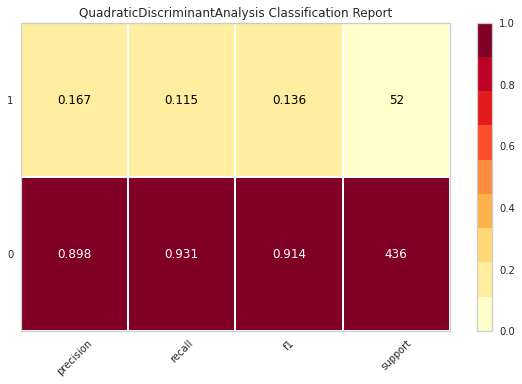

In [175]:
# Plotting the classification report
plot_model(estimator = qda, plot = 'class_report')

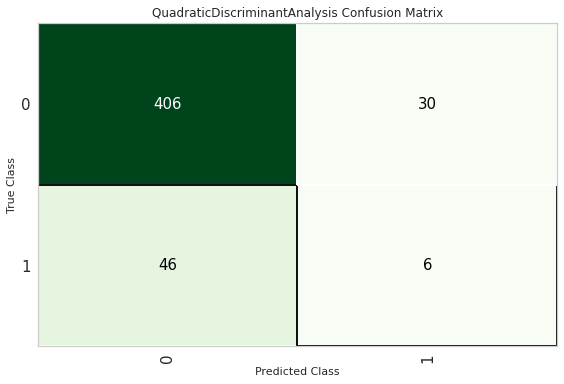

In [176]:
# Plotting the confusion matrix
plot_model(estimator = qda, plot = 'confusion_matrix')

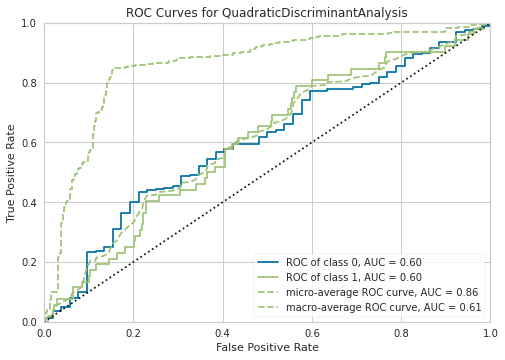

In [177]:
# Plotting the AUC
plot_model(estimator = qda, plot = 'auc')

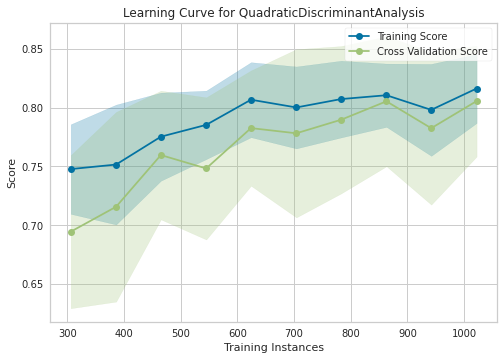

In [178]:
# Plotting the learning curve
plot_model(estimator = qda, plot = 'learning' )

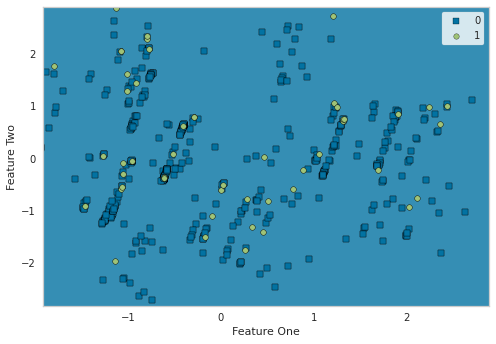

In [179]:
plot_model(estimator = qda, plot='boundary')

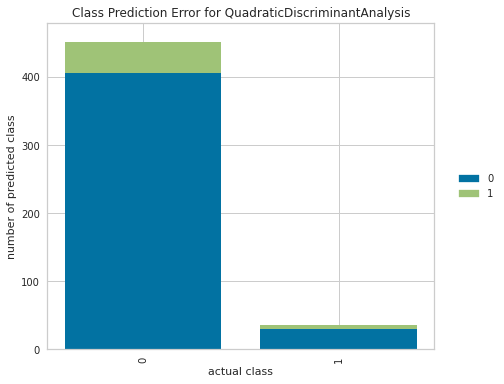

In [180]:
plot_model(estimator = qda, plot = 'error')

In [181]:
evaluate_model(estimator = qda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Tuned model: qda

In [182]:
# tune hyperparameters to optimize AUC
tuned_qda = tune_model(qda, optimize = 'recall', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8246,0.5139,0.2500,0.2143,0.2308,0.1324,0.1329
1,0.8684,0.6283,0.0833,0.2000,0.1176,0.0594,0.0661
2,0.7982,0.6585,0.1667,0.1333,0.1481,0.0353,0.0356
3,0.6842,0.4158,0.1667,0.0714,0.1000,-0.0556,-0.0629
4,0.7105,0.6038,0.3333,0.1379,0.1951,0.0543,0.0622
5,0.8772,0.7144,0.2308,0.4286,0.3000,0.2393,0.2531
6,0.7611,0.6675,0.3333,0.1739,0.2286,0.1034,0.1111
7,0.7611,0.5462,0.1667,0.1053,0.1290,-0.0013,-0.0014
8,0.7080,0.4934,0.2500,0.1111,0.1538,0.0080,0.0089
9,0.8319,0.6510,0.4167,0.2941,0.3448,0.2517,0.2567


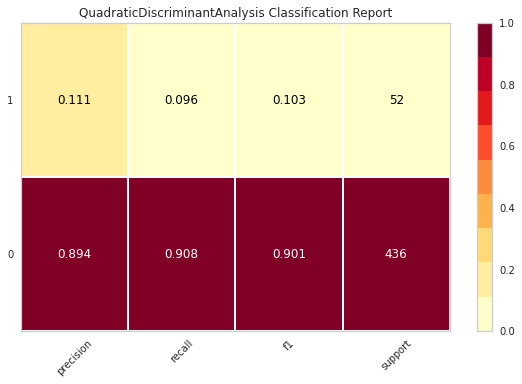

In [183]:
# Plotting the classification report
plot_model(estimator = tuned_qda, plot = 'class_report')

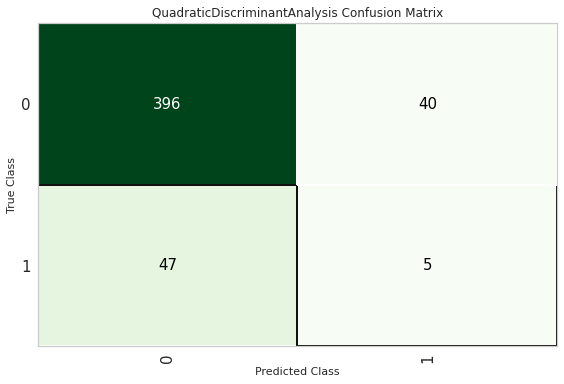

In [184]:
# Plotting the confusion matrix
plot_model(estimator = tuned_qda, plot = 'confusion_matrix')

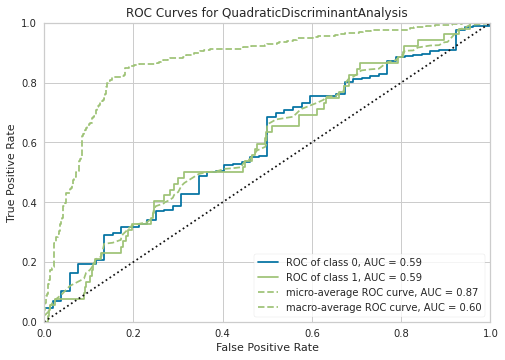

In [185]:
# Plotting the AUC
plot_model(estimator = tuned_qda, plot = 'auc')

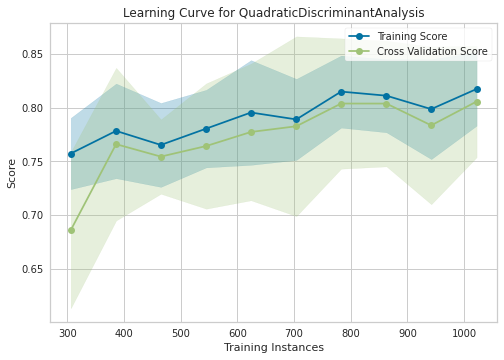

In [186]:
# Plotting the learning curve
plot_model(estimator = tuned_qda, plot = 'learning' )

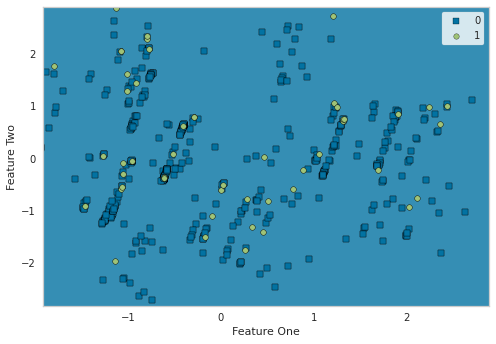

In [187]:
plot_model(estimator = tuned_qda, plot='boundary')

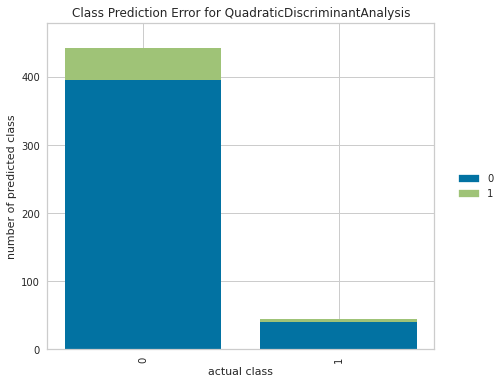

In [188]:
plot_model(estimator = tuned_qda, plot = 'error')

In [189]:
evaluate_model(estimator = tuned_qda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Random Forest

In [157]:
# Best ML analysis
rf = create_model(estimator = 'rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8772,0.6818,0.2500,0.3750,0.3000,0.2356,0.2415
1,0.8421,0.6246,0.0833,0.1250,0.1000,0.0172,0.0177
2,0.8772,0.7063,0.0000,0.0000,0.0000,-0.0310,-0.0458
3,0.8421,0.5764,0.1667,0.2000,0.1818,0.0952,0.0957
4,0.8509,0.6246,0.2500,0.2727,0.2609,0.1781,0.1783
5,0.9035,0.8423,0.3077,0.6667,0.4211,0.3761,0.4098
6,0.8938,0.7376,0.5000,0.5000,0.5000,0.4406,0.4406
7,0.8496,0.7331,0.1667,0.2222,0.1905,0.1094,0.1108
8,0.8230,0.6964,0.2500,0.2143,0.2308,0.1314,0.1319
9,0.8584,0.7591,0.2500,0.3000,0.2727,0.1950,0.1960


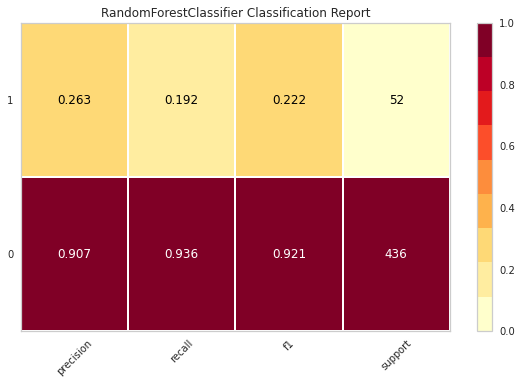

In [158]:
# Plotting the classification report
plot_model(estimator = rf, plot = 'class_report')

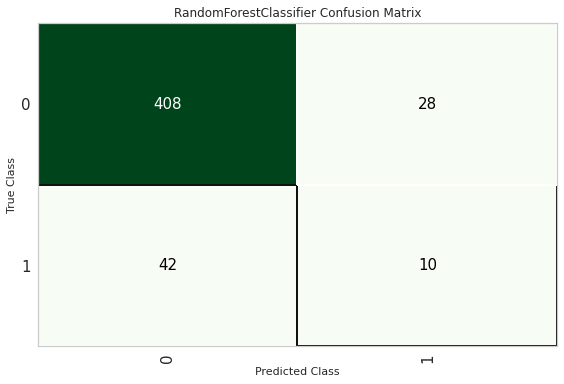

In [159]:
# Plotting the confusion matrix
plot_model(estimator = rf, plot = 'confusion_matrix')

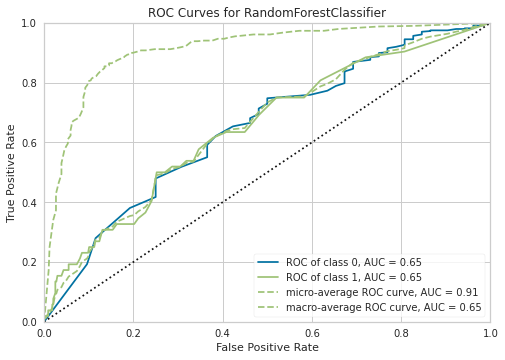

In [160]:
# Plotting the AUC
plot_model(estimator = rf, plot = 'auc')

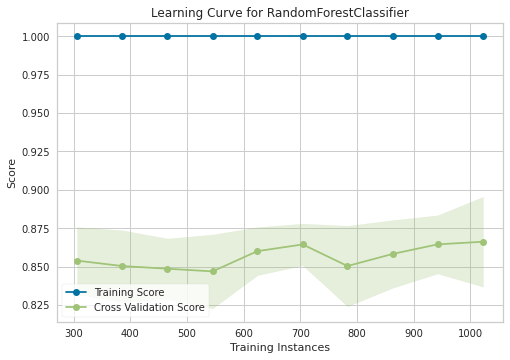

In [161]:
# Plotting the learning curve
plot_model(estimator = rf, plot = 'learning' )

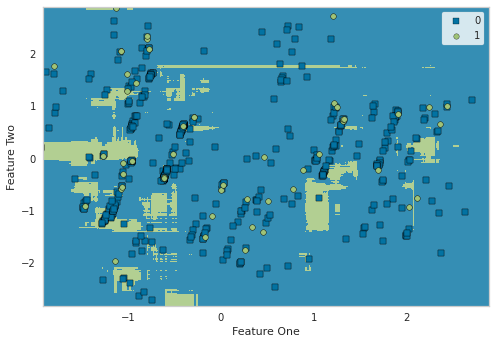

In [162]:
plot_model(estimator = rf, plot='boundary')

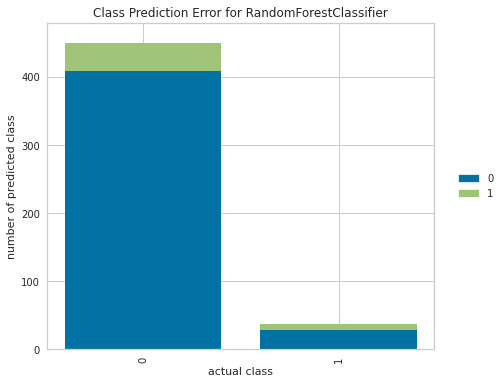

In [163]:
plot_model(estimator = rf, plot = 'error')

In [164]:
evaluate_model(estimator = rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Tuned model: rf

In [165]:
# tune hyperparameters to optimize AUC
tuned_rf = tune_model(rf, optimize = 'recall', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.1053,0.5000,1.0000,0.1053,0.1905,0.0000,0.0000
1,0.8947,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.1053,0.5000,1.0000,0.1053,0.1905,0.0000,0.0000
3,0.1053,0.5000,1.0000,0.1053,0.1905,0.0000,0.0000
4,0.1053,0.5000,1.0000,0.1053,0.1905,0.0000,0.0000
5,0.1140,0.5000,1.0000,0.1140,0.2047,0.0000,0.0000
6,0.1062,0.5000,1.0000,0.1062,0.1920,0.0000,0.0000
7,0.1062,0.5000,1.0000,0.1062,0.1920,0.0000,0.0000
8,0.1062,0.5000,1.0000,0.1062,0.1920,0.0000,0.0000
9,0.1062,0.5000,1.0000,0.1062,0.1920,0.0000,0.0000


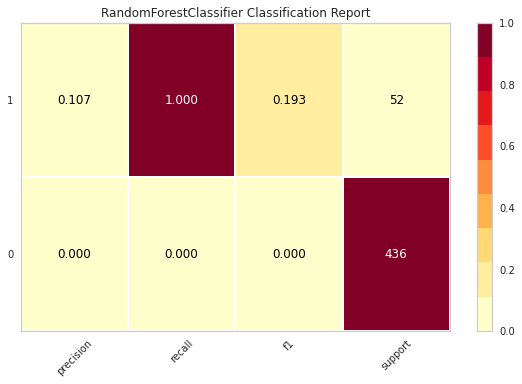

In [166]:
# Plotting the classification report
plot_model(estimator = tuned_rf, plot = 'class_report')

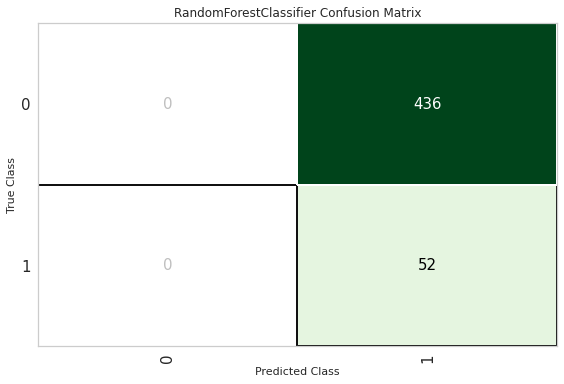

In [167]:
# Plotting the confusion matrix
plot_model(estimator = tuned_rf, plot = 'confusion_matrix')

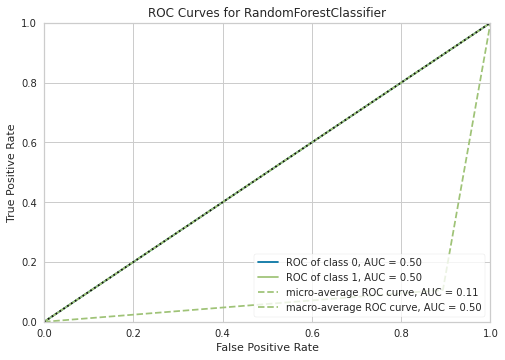

In [168]:
# Plotting the AUC
plot_model(estimator = tuned_rf, plot = 'auc')

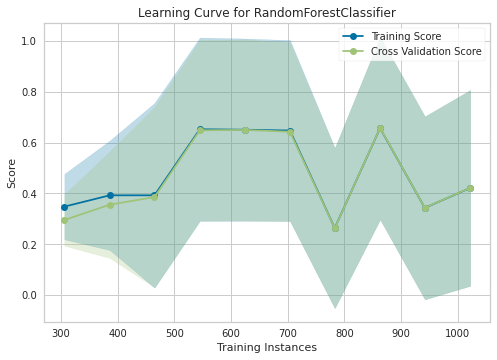

In [169]:
# Plotting the learning curve
plot_model(estimator = tuned_rf, plot = 'learning' )

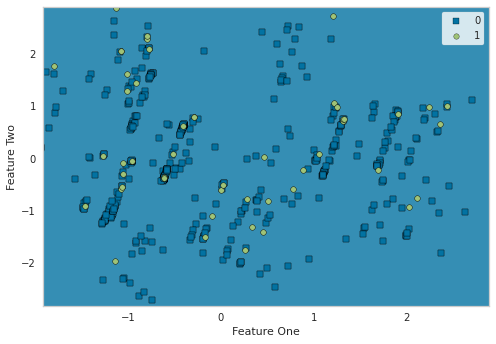

In [170]:
plot_model(estimator = tuned_rf, plot='boundary')

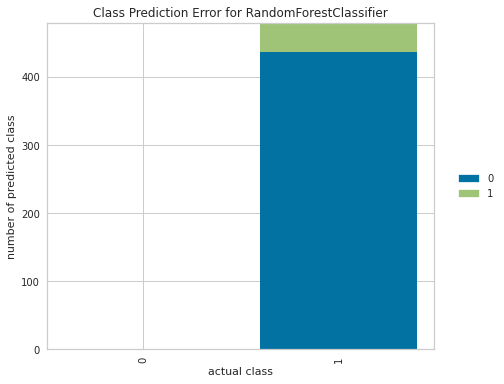

In [171]:
plot_model(estimator = tuned_rf, plot = 'error')

In [172]:
evaluate_model(estimator = tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Linear Discriminant Analysis

In [109]:
# Best ML analysis
lda = create_model(estimator = 'lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8246,0.5359,0.0833,0.1000,0.0909,-0.0053,-0.0053
1,0.9035,0.6912,0.0833,1.0000,0.1538,0.1399,0.2743
2,0.8070,0.7051,0.1667,0.1429,0.1538,0.0457,0.0458
3,0.6754,0.4575,0.1667,0.0690,0.0976,-0.0603,-0.0691
4,0.7105,0.5662,0.4167,0.1613,0.2326,0.0952,0.1116
5,0.8509,0.6961,0.0769,0.1667,0.1053,0.0358,0.0390
6,0.8142,0.6345,0.2500,0.2000,0.2222,0.1182,0.1191
7,0.8053,0.5726,0.0833,0.0833,0.0833,-0.0256,-0.0256
8,0.7434,0.4917,0.2500,0.1304,0.1714,0.0370,0.0398
9,0.8319,0.6576,0.5000,0.3158,0.3871,0.2954,0.3059


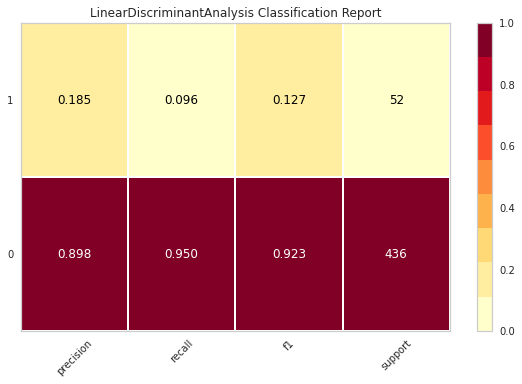

In [110]:
# Plotting the classification report
plot_model(estimator = lda, plot = 'class_report')

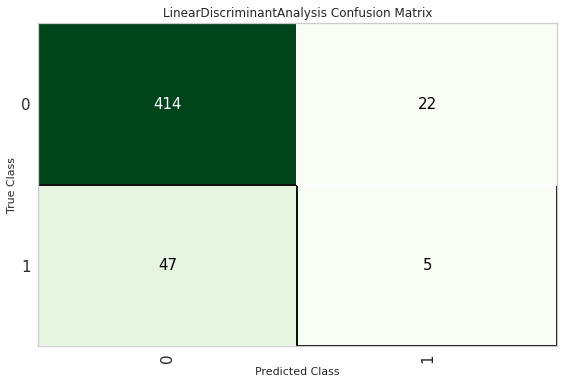

In [111]:
# Plotting the confusion matrix
plot_model(estimator = lda, plot = 'confusion_matrix')

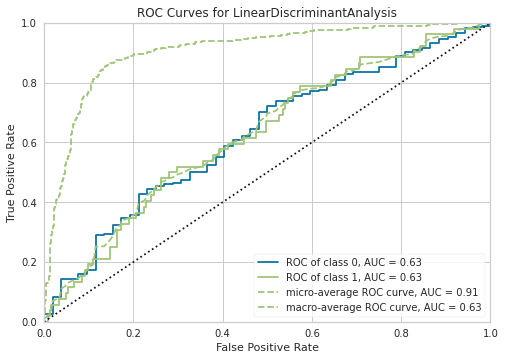

In [112]:
# Plotting the AUC
plot_model(estimator = lda, plot = 'auc')

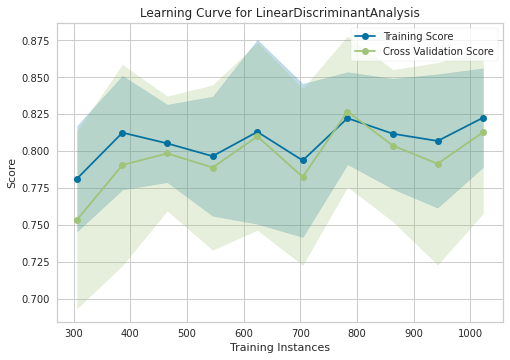

In [113]:
# Plotting the learning curve
plot_model(estimator = lda, plot = 'learning' )

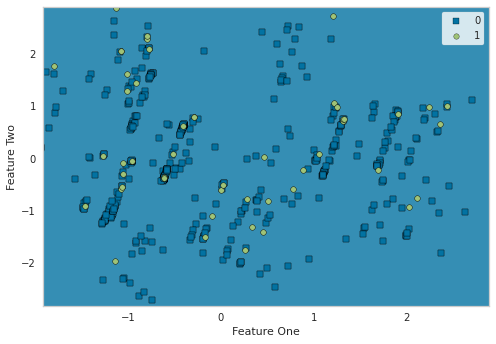

In [114]:
plot_model(estimator = lda, plot='boundary')

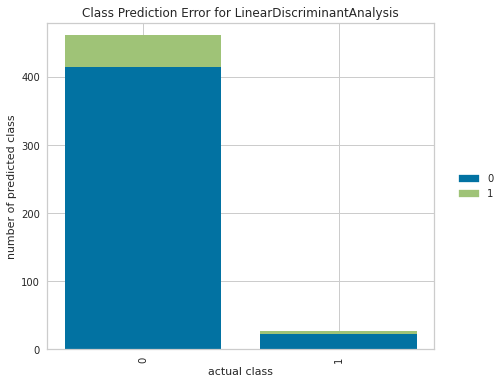

In [115]:
plot_model(estimator = lda, plot = 'error')

In [116]:
evaluate_model(estimator = lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Tuned model: lda

In [117]:
# tune hyperparameters to optimize AUC
tuned_lda = tune_model(lda, optimize = 'recall', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8421,0.5294,0.0833,0.1250,0.1000,0.0172,0.0177
1,0.9035,0.6806,0.0833,1.0000,0.1538,0.1399,0.2743
2,0.8070,0.6904,0.1667,0.1429,0.1538,0.0457,0.0458
3,0.6930,0.4690,0.1667,0.0741,0.1026,-0.0506,-0.0566
4,0.7193,0.5719,0.4167,0.1667,0.2381,0.1032,0.1196
5,0.8860,0.7083,0.0769,0.5000,0.1333,0.1062,0.1623
6,0.8230,0.6551,0.2500,0.2143,0.2308,0.1314,0.1319
7,0.8230,0.5421,0.0833,0.1000,0.0909,-0.0062,-0.0063
8,0.7434,0.4884,0.1667,0.0952,0.1212,-0.0161,-0.0170
9,0.8142,0.6535,0.5000,0.2857,0.3636,0.2642,0.2784


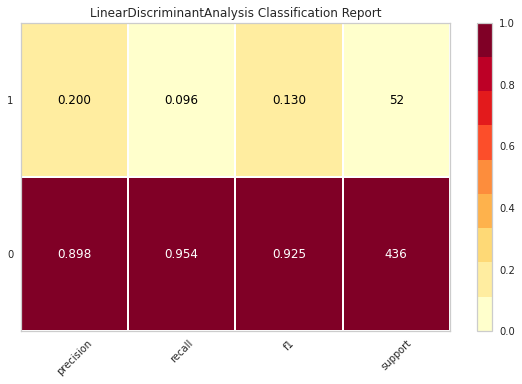

In [118]:
# Plotting the classification report
plot_model(estimator = tuned_lda, plot = 'class_report')

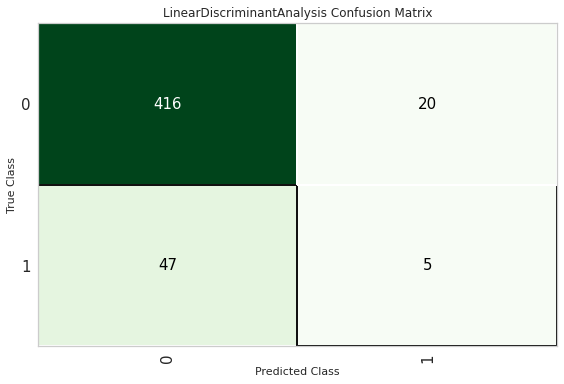

In [119]:
# Plotting the confusion matrix
plot_model(estimator = tuned_lda, plot = 'confusion_matrix')

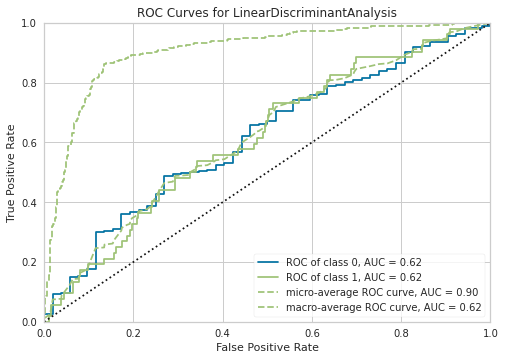

In [120]:
# Plotting the AUC
plot_model(estimator = tuned_lda, plot = 'auc')

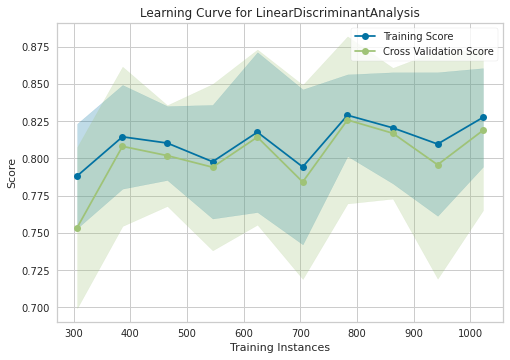

In [121]:
# Plotting the learning curve
plot_model(estimator = tuned_lda, plot = 'learning' )

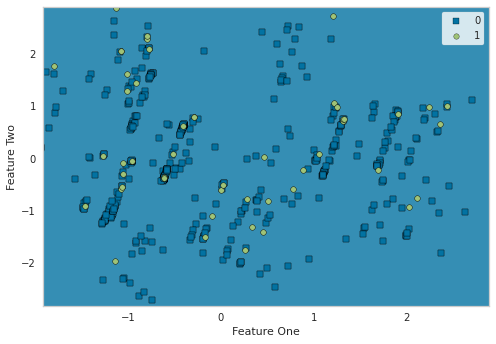

In [122]:
plot_model(estimator = tuned_lda, plot='boundary')

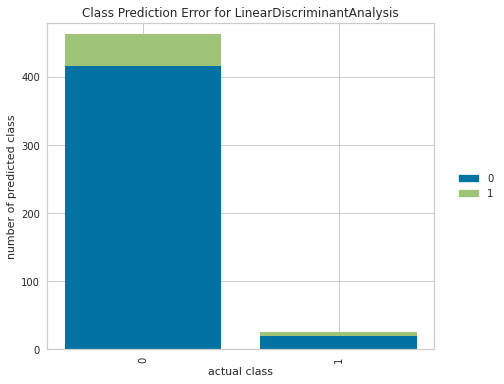

In [123]:
plot_model(estimator = tuned_lda, plot = 'error')

In [124]:
evaluate_model(estimator = tuned_lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Logistic Regression

In [125]:
# Best ML analysis
lr = create_model(estimator = 'lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8246,0.5351,0.0833,0.1000,0.0909,-0.0053,-0.0053
1,0.9035,0.6895,0.0833,1.0000,0.1538,0.1399,0.2743
2,0.8070,0.7010,0.0833,0.0833,0.0833,-0.0245,-0.0245
3,0.6842,0.4583,0.1667,0.0714,0.1000,-0.0556,-0.0629
4,0.7105,0.5711,0.3333,0.1379,0.1951,0.0543,0.0622
5,0.8684,0.6984,0.0769,0.2500,0.1176,0.0676,0.0816
6,0.8230,0.6370,0.3333,0.2500,0.2857,0.1871,0.1896
7,0.8142,0.5668,0.0833,0.0909,0.0870,-0.0163,-0.0163
8,0.7522,0.4917,0.2500,0.1364,0.1765,0.0453,0.0481
9,0.8319,0.6543,0.5000,0.3158,0.3871,0.2954,0.3059


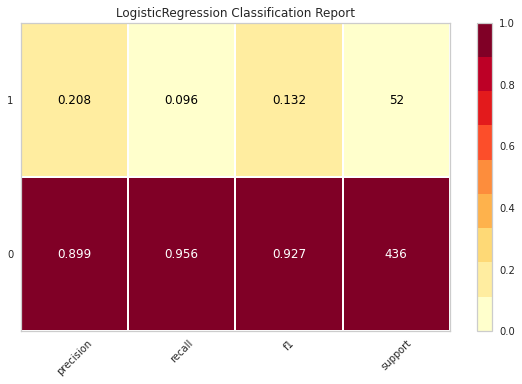

In [126]:
# Plotting the classification report
plot_model(estimator = lr, plot = 'class_report')

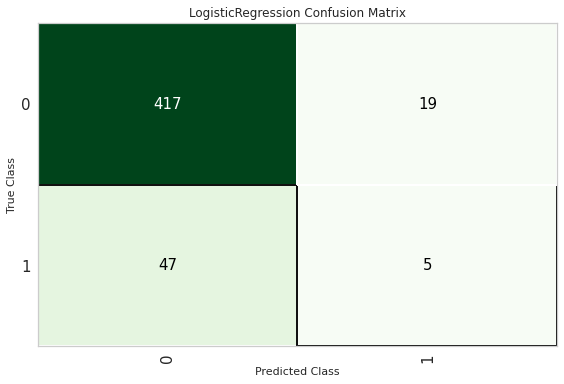

In [127]:
# Plotting the confusion matrix
plot_model(estimator = lr, plot = 'confusion_matrix')

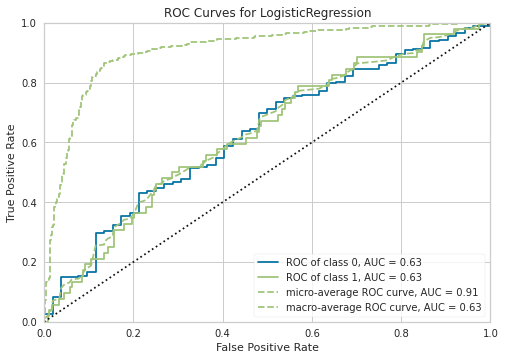

In [128]:
# Plotting the AUC
plot_model(estimator = lr, plot = 'auc')

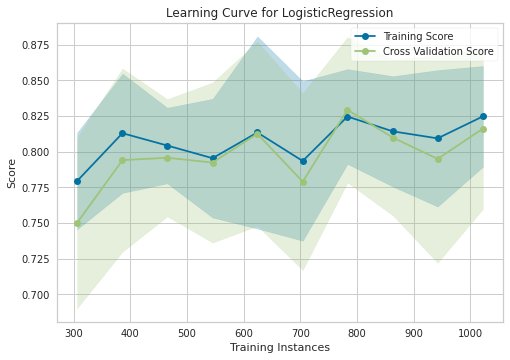

In [129]:
# Plotting the learning curve
plot_model(estimator = lr, plot = 'learning' )

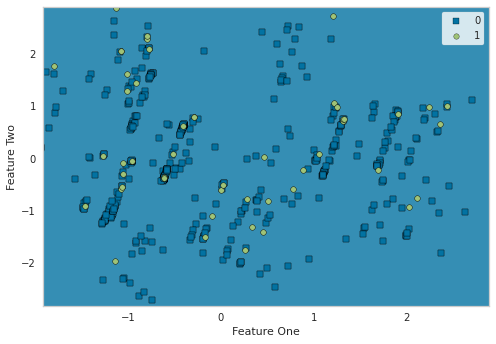

In [130]:
plot_model(estimator = lr, plot='boundary')

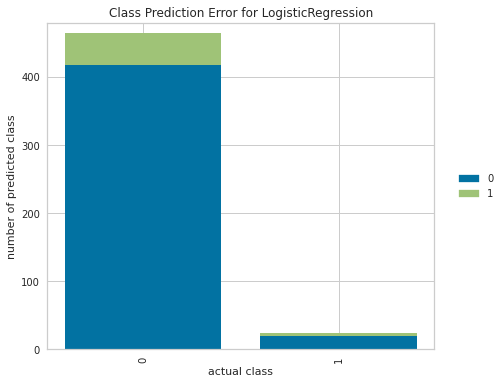

In [131]:
plot_model(estimator = lr, plot = 'error')

In [132]:
evaluate_model(estimator = lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Tuned model: lr

In [133]:
# tune hyperparameters to optimize AUC
tuned_lr = tune_model(lr, optimize = 'recall', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6491,0.5392,0.4167,0.1316,0.2000,0.0476,0.0606
1,0.6579,0.6887,0.5833,0.1707,0.2642,0.1210,0.1599
2,0.6404,0.6993,0.6667,0.1778,0.2807,0.1373,0.1908
3,0.5789,0.4477,0.2500,0.0714,0.1111,-0.0629,-0.0842
4,0.6053,0.5743,0.5000,0.1333,0.2105,0.0532,0.0739
5,0.6140,0.6923,0.8462,0.2075,0.3333,0.1839,0.2742
6,0.6195,0.6353,0.5000,0.1395,0.2182,0.0625,0.0848
7,0.5752,0.5693,0.2500,0.0714,0.1111,-0.0648,-0.0868
8,0.5929,0.4926,0.3333,0.0952,0.1481,-0.0204,-0.0274
9,0.6018,0.6551,0.5833,0.1489,0.2373,0.0820,0.1171


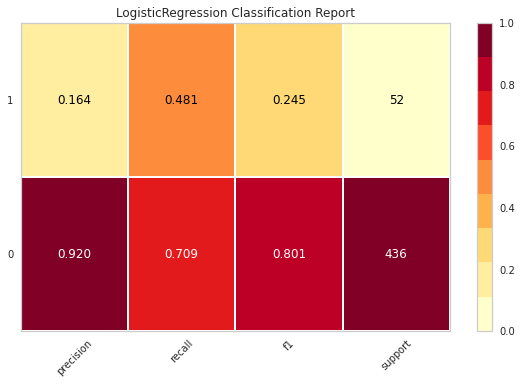

In [134]:
# Plotting the classification report
plot_model(estimator = tuned_lr, plot = 'class_report')

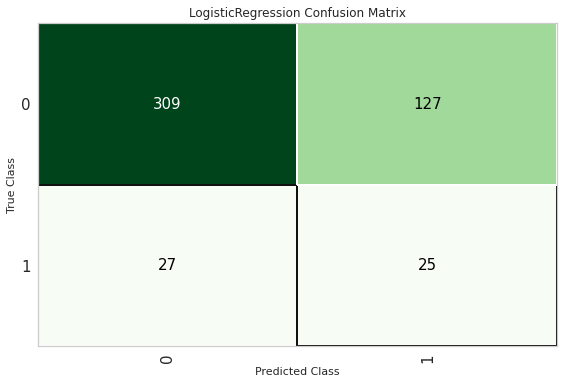

In [135]:
# Plotting the confusion matrix
plot_model(estimator = tuned_lr, plot = 'confusion_matrix')

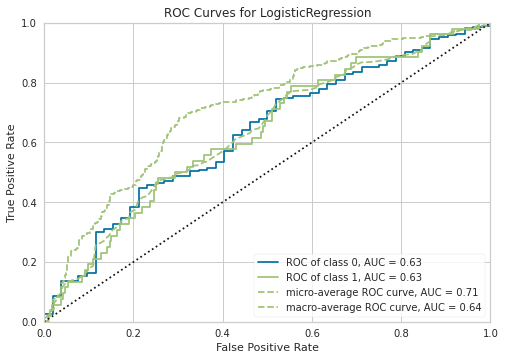

In [136]:
# Plotting the AUC
plot_model(estimator = tuned_lr, plot = 'auc')

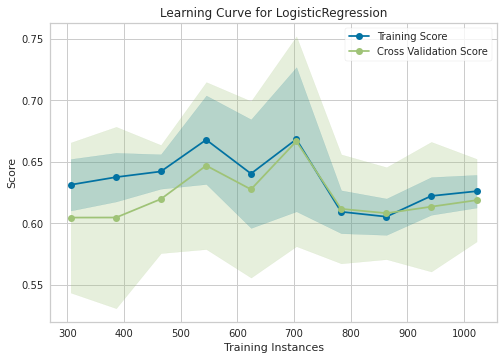

In [137]:
# Plotting the learning curve
plot_model(estimator = tuned_lr, plot = 'learning' )

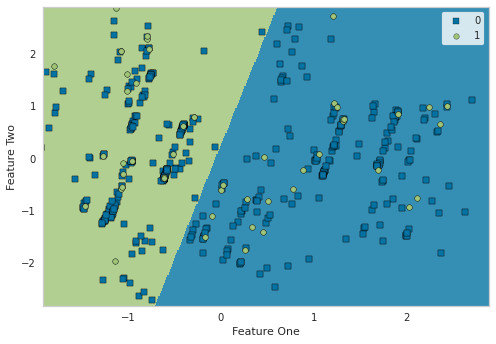

In [138]:
plot_model(estimator = tuned_lr, plot='boundary')

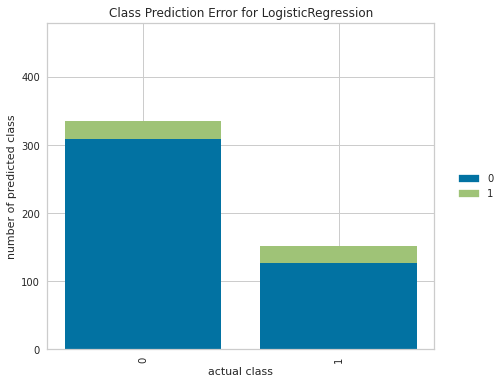

In [139]:
plot_model(estimator = tuned_lr, plot = 'error')

In [140]:
evaluate_model(estimator = tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Naive Bayes

In [141]:
# Best ML analysis
nb = create_model(estimator = 'nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7895,0.5572,0.1667,0.1250,0.1429,0.0256,0.0260
1,0.8947,0.6977,0.0833,0.5000,0.1429,0.1163,0.1719
2,0.7719,0.6062,0.1667,0.1111,0.1333,0.0080,0.0083
3,0.6579,0.4600,0.1667,0.0645,0.0930,-0.0693,-0.0811
4,0.6404,0.5596,0.3333,0.1081,0.1633,0.0051,0.0064
5,0.8596,0.7182,0.2308,0.3333,0.2727,0.1979,0.2020
6,0.7345,0.6708,0.4167,0.1786,0.2500,0.1190,0.1348
7,0.7522,0.5099,0.1667,0.1000,0.1250,-0.0089,-0.0093
8,0.7080,0.4868,0.2500,0.1111,0.1538,0.0080,0.0089
9,0.7345,0.6790,0.5000,0.2000,0.2857,0.1580,0.1831


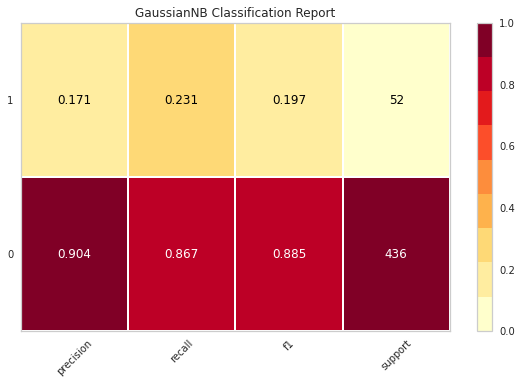

In [142]:
# Plotting the classification report
plot_model(estimator = nb, plot = 'class_report')

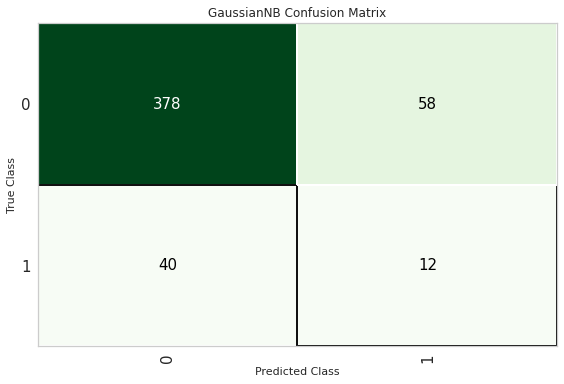

In [143]:
# Plotting the confusion matrix
plot_model(estimator = nb, plot = 'confusion_matrix')

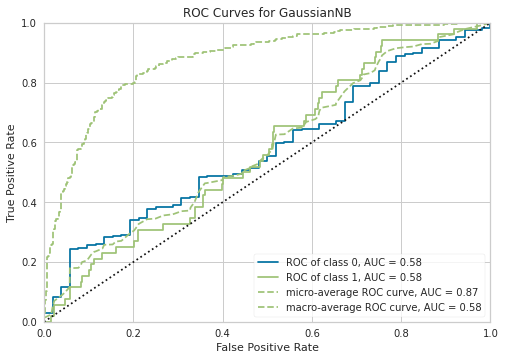

In [144]:
# Plotting the AUC
plot_model(estimator = nb, plot = 'auc')

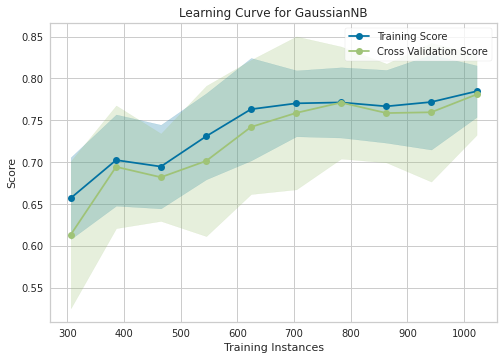

In [145]:
# Plotting the learning curve
plot_model(estimator = nb, plot = 'learning' )

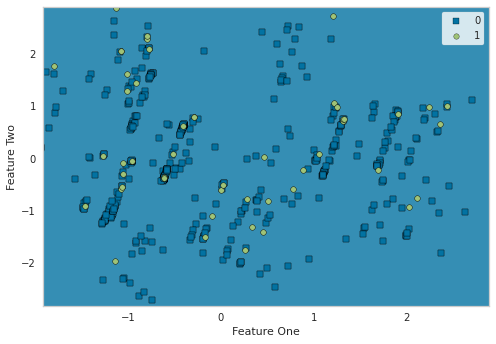

In [146]:
plot_model(estimator = nb, plot='boundary')

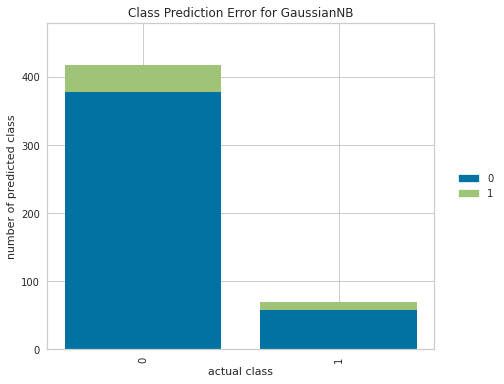

In [147]:
plot_model(estimator = nb, plot = 'error')

In [148]:
evaluate_model(estimator = nb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Tuned model: nb

In [149]:
# tune hyperparameters to optimize AUC
tuned_nb = tune_model(nb, optimize = 'recall', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7895,0.5572,0.1667,0.1250,0.1429,0.0256,0.0260
1,0.8947,0.6977,0.0833,0.5000,0.1429,0.1163,0.1719
2,0.7719,0.6062,0.1667,0.1111,0.1333,0.0080,0.0083
3,0.6579,0.4600,0.1667,0.0645,0.0930,-0.0693,-0.0811
4,0.6404,0.5596,0.3333,0.1081,0.1633,0.0051,0.0064
5,0.8596,0.7182,0.2308,0.3333,0.2727,0.1979,0.2020
6,0.7345,0.6708,0.4167,0.1786,0.2500,0.1190,0.1348
7,0.7522,0.5099,0.1667,0.1000,0.1250,-0.0089,-0.0093
8,0.7080,0.4868,0.2500,0.1111,0.1538,0.0080,0.0089
9,0.7345,0.6790,0.5000,0.2000,0.2857,0.1580,0.1831


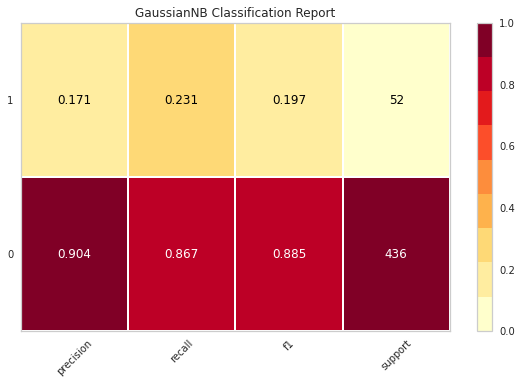

In [150]:
# Plotting the classification report
plot_model(estimator = tuned_nb, plot = 'class_report')

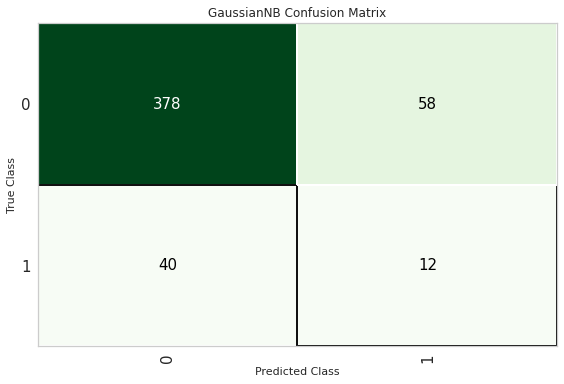

In [151]:
# Plotting the confusion matrix
plot_model(estimator = tuned_nb, plot = 'confusion_matrix')

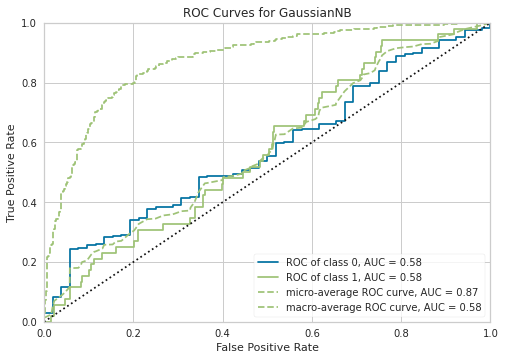

In [152]:
# Plotting the AUC
plot_model(estimator = tuned_nb, plot = 'auc')

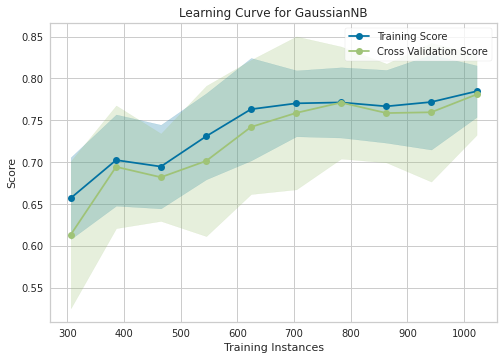

In [153]:
# Plotting the learning curve
plot_model(estimator = tuned_nb, plot = 'learning' )

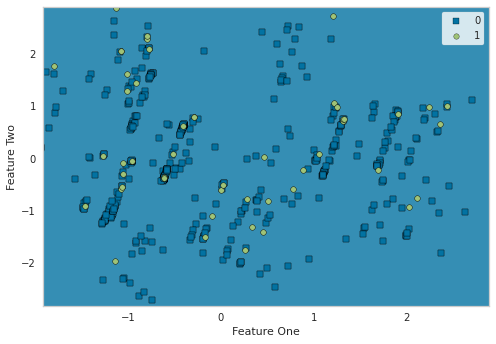

In [154]:
plot_model(estimator = tuned_nb, plot='boundary')

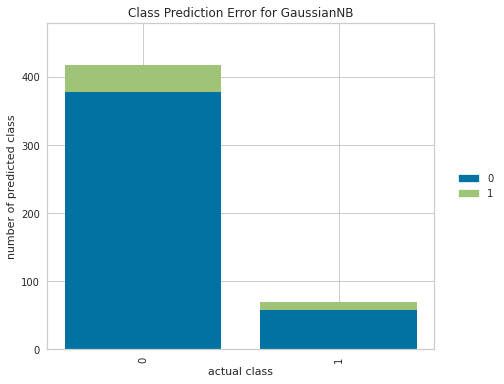

In [155]:
plot_model(estimator = tuned_nb, plot = 'error')

In [156]:
evaluate_model(estimator = tuned_nb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [190]:
# finalize a model
final_tuned_nb = finalize_model(tuned_nb)

In [191]:
# save a model
save_model(final_tuned_nb, base_dir + 'models/tuned_nb')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Title_title',
                                                        'Review_content',
                                                        'Title_Dominant_Topic',
                                                        'Title_Perc_Dominant_Topic',
                                                        'Review_Dominant_Topic',
                                                        'Review_Perc_Dominant_Topic'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='sentiment_rating',
                                       time...
                 ('binn', 'passthrough'), ('rem_ou

## Loading model

In [192]:
# Loading the saved model
tuned_nb_model = load_model(base_dir + 'models/tuned_nb')
tuned_nb_model

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['Title_title',
                                                       'Review_content',
                                                       'Title_Dominant_Topic',
                                                       'Title_Perc_Dominant_Topic',
                                                       'Review_Dominant_Topic',
                                                       'Review_Perc_Dominant_Topic'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='sentiment_rating',
                                      time...
                ('binn', 'passthrough'), ('rem_outliers', 'passth